In [1]:
import torch.nn as nn
import pandas as pd
import json
import os
import numpy as np
import pickle
import json
import scipy
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# ========== FUNCTION ==============

In [2]:
# prepare input for AEs, 
# input is combined list of all intersections (vector -> [fpds + hourofday+ weekofday + intersectoion]) for each week and each hour sorted based on time
# output is -> list of feature vector and time for all interctions combined --> [[fpds + hourofday+ weekofday + intersectoion], time]
def prepare_input_for_AEs(featured_fpds):
    combined_fpds_for_AEs = []
    for intersection in featured_fpds.keys():
        for i in range(7):
            for j in range(24):
                for l,m in zip(featured_fpds[intersection][i][j][0],featured_fpds[intersection][i][j][1]):
                    combined_fpds_for_AEs.append([l.astype(np.float32),m, intersection])

    combined_fpds_for_AEs = sorted(combined_fpds_for_AEs, key=lambda x:x[1])
    return np.array(combined_fpds_for_AEs)

In [3]:
# function to load data from pickle file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
def my_collate(batch):
    # Transpose the batch to get a list of samples
    transposed = zip(*batch)
    
    # Convert each sample to a tensor
    tensor_list = [torch.tensor(samples) for samples in transposed]
    
    # Return the list of tensors
    return tensor_list

In [5]:
class AutoEncoderDataset(Dataset):
    def __init__(self, data):
        self.data = data[:,0]
        self.timestamp = data[:,1]
        self.intersection = data[:,2]
        self.dim = self.data[0].shape[0]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # get integer
        my_int = self.data[idx]
        
        # get numpy datetime64 timestamp
        my_timestamp = str(self.timestamp[idx])
        
        # get string type
        my_str = str(self.intersection[idx])
        
        # return as list
        return [my_int, my_timestamp, my_str]

In [6]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_shape),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

# =========== MAIN ===========

In [7]:
# load data from pickle file
direction = "North"
trajectory = "T1"
load_fpds_path = f"../data/hauge/processed/featured_fpds_{direction}_{trajectory}.pickle"
featured_fpds = load_pickle(load_fpds_path)

In [8]:
# prepare input for AEs
combined_fpds_for_AEs = prepare_input_for_AEs(featured_fpds)

In [9]:
AE_dataset = AutoEncoderDataset(combined_fpds_for_AEs)  # create dataset object
AE_dataset.dim # feature vector dimension

23

In [10]:
train_dataloader = DataLoader(AE_dataset, batch_size=1, shuffle=False)
# train_dataloader = DataLoader(AE_dataset, batch_size=1, shuffle=False, collate_fn=my_collate)

In [11]:
# check if dataloader is working
for i in train_dataloader:
    print(i)
    break

[tensor([[0.0617, 0.0062, 0.0185, 0.0432, 0.0309, 0.0741, 0.0617, 0.1173, 0.1667,
         0.1543, 0.1667, 0.0988, 0.0417, 0.1429, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]), ('2018-01-01 00:00:00',), ('K502',)]


In [12]:
# define model parameters
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
epochs = 1
metrics = defaultdict(list)
outlier_loss = []
outlier_results = []
device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [13]:
model = AE(AE_dataset.dim)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [14]:
# train model
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, data in enumerate(train_dataloader):
        bt = data[0]
        sensor_time = data[1]
        intersection = data[2]     
        sample = model(bt.to(device))
        loss = criterion(bt.to(device), sample) # calculate loss for input and recreated output
        outlier_loss.append(loss.item()) # append loss to list
        outlier_results.append([loss.item(),sensor_time, intersection]) # append loss, time and intersection to list
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print average loss for every 25% batches
        if bx % int(AE_dataset.__len__()/4) == 0:
            print('[EPOCH] {}/{}\t[BATCH] {}/{}\t[LOSS] {}'.format(epoch+1,epochs,bx+1,AE_dataset.__len__(),running_loss/(bx+1)))
    epoch_loss = running_loss/AE_dataset.__len__()
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

[EPOCH] 1/1	[BATCH] 1/162897	[LOSS] 0.047332629561424255
[EPOCH] 1/1	[BATCH] 40725/162897	[LOSS] 0.04966070758365209
[EPOCH] 1/1	[BATCH] 81449/162897	[LOSS] 0.04953701589247149
[EPOCH] 1/1	[BATCH] 122173/162897	[LOSS] 0.04939357157536129
[EPOCH] 1/1	[BATCH] 162897/162897	[LOSS] 0.04934729686964897
-----------------------------------------------
[EPOCH] 1/1
[LOSS] 0.04934729686964897
Epoch Complete in 0:22:02.237209
-----------------------------------------------
[System Complete: 0:22:02.237386]


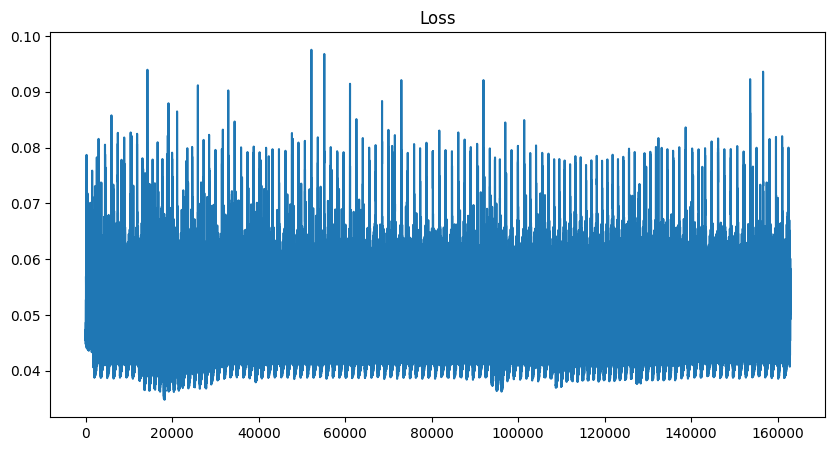

In [15]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(outlier_loss)

In [23]:
# get the top 5% of the loss values
top_5_percent = np.percentile(outlier_loss, 97)
top_5_percent

0.06490769505500793

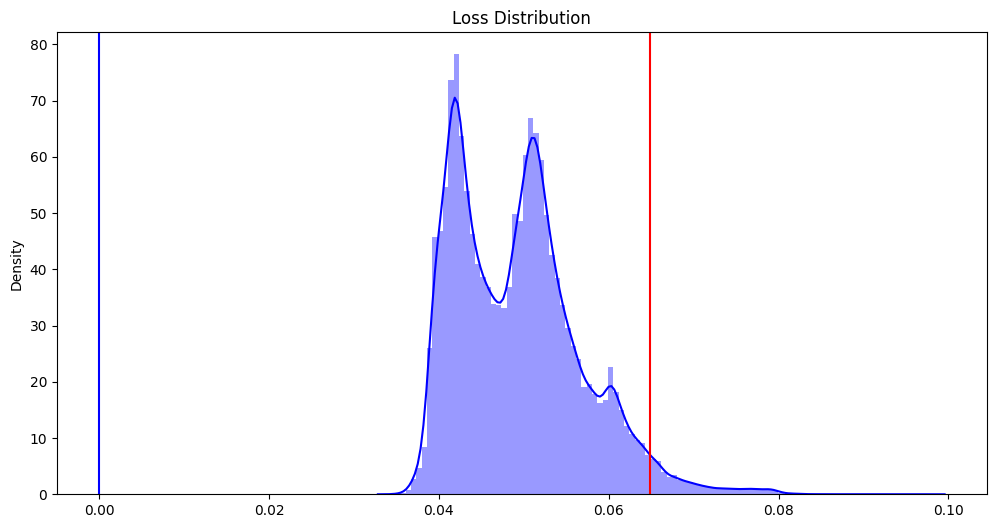

In [24]:
lower_threshold = 0.0
upper_threshold = top_5_percent
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(outlier_loss,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

<Axes: >

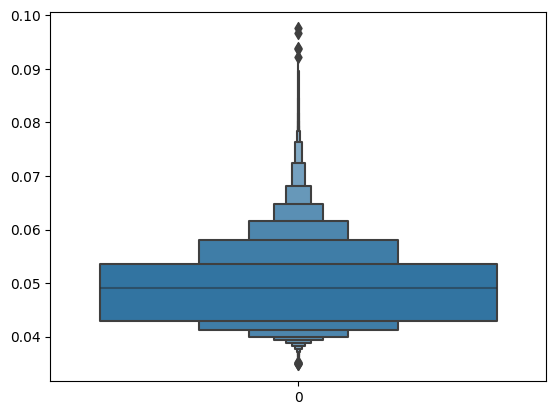

In [25]:
sns.boxenplot(outlier_loss)

In [78]:
outlier_df = pd.DataFrame(outlier_results,columns=['loss','timestamp','intersection'])
outlier_df.head()

,loss,timestamp,intersection
0,0.047333,"(2018-01-01 00:00:00,)","(K502,)"
1,0.045658,"(2018-01-01 01:00:00,)","(K502,)"
2,0.048240,"(2018-01-01 01:00:00,)","(K504,)"
3,0.047685,"(2018-01-01 01:00:00,)","(K503,)"
4,0.047336,"(2018-01-01 01:00:00,)","(K263,)"


In [79]:
outlier_df['timestamp'] = outlier_df['timestamp'].apply(lambda x: x[0])
outlier_df['intersection'] = outlier_df['intersection'].apply(lambda x: x[0])

In [85]:
# create seperate columns for each intersection
outlier_df_intersection = outlier_df.pivot(index='timestamp', columns='intersection', values='loss')

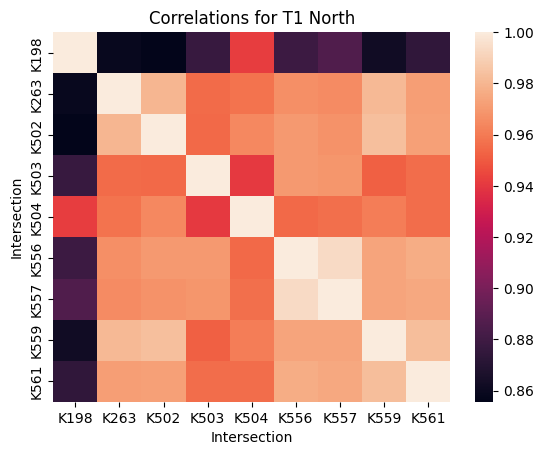

In [86]:
fig, ax = plt.subplots(facecolor='w')
sns.heatmap(outlier_df_intersection.corr())
plt.title("Correlations for T1 North")
plt.xlabel('Intersection')
plt.ylabel('Intersection')
plt.show()

In [89]:
corr_df = outlier_df_intersection.corr()
corr_df

intersection,K198,K263,K502,K503,K504,K556,K557,K559,K561
intersection,,,,,,,,,
K198,1.000000,0.858969,0.855700,0.876821,0.941535,0.878711,0.885909,0.862261,0.873933
K263,0.858969,1.000000,0.979711,0.955008,0.957613,0.966272,0.965140,0.981208,0.971364
K502,0.855700,0.979711,1.000000,0.954824,0.964305,0.970087,0.967824,0.983142,0.972013
K503,0.876821,0.955008,0.954824,1.000000,0.940753,0.969787,0.968760,0.951527,0.955668
K504,0.941535,0.957613,0.964305,0.940753,1.000000,0.954502,0.956067,0.960595,0.955847
K556,0.878711,0.966272,0.970087,0.969787,0.954502,1.000000,0.993521,0.973729,0.976356
K557,0.885909,0.965140,0.967824,0.968760,0.956067,0.993521,1.000000,0.973787,0.975118
K559,0.862261,0.981208,0.983142,0.951527,0.960595,0.973729,0.973787,1.000000,0.982927
K561,0.873933,0.971364,0.972013,0.955668,0.955847,0.976356,0.975118,0.982927,1.000000


### Comments over correlated intersections
- Except K198 all intersections are highly correlated
- hard to get the intution as the feature vector is - **[fpds + hourofday+ weekofday + intersectoion]**

In [91]:
# for each intersection, get the top 3 correlated intersections
top_3_corr = corr_df.apply(lambda x: x.sort_values(ascending=False).index[1:4], axis=1)
top_3_corr

intersection
K198    Index(['K504', 'K557', 'K556'], dtype='object'...
K263    Index(['K559', 'K502', 'K561'], dtype='object'...
K502    Index(['K559', 'K263', 'K561'], dtype='object'...
K503    Index(['K556', 'K557', 'K561'], dtype='object'...
K504    Index(['K502', 'K559', 'K263'], dtype='object'...
K556    Index(['K557', 'K561', 'K559'], dtype='object'...
K557    Index(['K556', 'K561', 'K559'], dtype='object'...
K559    Index(['K502', 'K561', 'K263'], dtype='object'...
K561    Index(['K559', 'K556', 'K557'], dtype='object'...
dtype: object